<a href="https://colab.research.google.com/github/gustvjor2005/blog-backend/blob/main/reber_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejemplo RNN usando pytorch para Reber Grammar

Para el entendimiento de Reber Gramamr y el modelo RNN se tomó como referencia http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php

In [1]:
import torch
import torch.nn as nn
import numpy as np
import reberGrammar

Si tenemos la secuencia de entrada (que obedece a la gramatica de Reber, es decir sigue un recorrido correcto del grafo) nuestra secuecia target esta compuesto de: uno de los posibles valores siguientes de cada uno de los elementos de nuestro input.

Por ejemplo para el input 'BPVPXTTTVPXVV' y target 'TTPSTTTTPSTPE':

    B -> T
    P -> T
    V -> P
    P -> S
    X -> T
    T -> T
    T -> T
    T -> T
    V -> P
    P -> S
    X -> T
    V -> P
    V -> E  

    Nota: en la secuencia de entrada no se considera la letra final 'E' , dado que esta no apunta a nigun otra.




In [7]:
#usamos Standar Reber Grammar

x, y = reberGrammar.get_one_example(10)

print(x, y)

#pasar input y target a palabras
x2word = reberGrammar.sequenceToWord(x)
y2word = reberGrammar.sequenceToWord(y)

print(x2word, y2word)

[array([1., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 0., 0., 1., 0.])] [array([0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 1., 0., 0., 0.]),

Modelo RNN

1. El tamaño de la secuencia del modelo RNN es igual al tamaño de caracteres generados, por ejemplo si tengo una sequencia 'BPVPXTTTVPXVV' , el tamaño será 13.

  Nota : no confundir el tamaño de la secuencia del modelo con el número de features del input (input_size). El primero determina la cantidad de celdas rnn que tendrá el modelo y para nuestro caso es dinamico (lo cual ocurre normalemnte en una rnn), el segundo es estatico (para nuestro caso 7).

2. En pytorch un cat (dim=1) es como agregar dos (o más) elementos sobre las columnas (o los features) , en este caso se agregan columnas del hidden respecto del input creando un nuevo tensor.




In [ ]:
class RNN(nn.Module):

  def __init__(self, in_size, hid_size, out_size):
    super().__init__()
    self.hid_size = hid_size
    self.i2h = nn.Linear(in_size + hid_size, hid_size)
    self.h2t = nn.Tanh()
    self.i2o = nn.Linear(hid_size, out_size)
    self.o2s = nn.Sigmoid()

  def forward(self, input, hidden):    
    c = torch.cat((input, hidden), 1)
    hidden = self.i2h(c)
    hidden = self.h2t(hidden)
    output = self.i2o(hidden)
    output = self.o2s(output)
    return output, hidden

  #la inizializacion del hidden es para cada secuencia
  #dado que los samples son independientes
  def initHidden(self):
    return torch.zeros(1, self.hid_size)

¿Cómo se determina el tamaño del hidden?

In [ ]:
#features del input
n_in = 7
#tamaño del hidden
n_hidden = 10
#tamaño del target
n_out = 7

rnn = RNN(n_in, n_hidden, n_out)

Funcion de perdida Binary Cross Entropy

¿El resultado es o no es el caracter que esperada?

Por ejemplo:

    B -> T 
    la representación del T es : [0, 1, 0, 0, 0, 0, 0]
    lo obtenido por el forward es: [0.2, .89, .32, .65, 0.2, 0.2, 0.2]
    entonces la perdida se analiza respecto a esos dos valores, pero para una secuencia completa

In [ ]:
def criterion(yhat, y):
  c = -torch.mean(y * torch.log(yhat) + (1 -y) * torch.log(1 -yhat))
  return c

#optimizador
optimizer = torch.optim.SGD(rnn.parameters(), lr=.2)

In [ ]:
# x: sequencia de entrada por ejemplo 'BPVPS'
# y: target, sequencia del salida, por ejemplo 'TTPSE'
def train(x, y):
  #por cada sequencia reiniciamos el hidden
  hidden = rnn.initHidden()
  #resultado de una secuencia
  outputs = []
  rnn.train()
  #recorremos las celdas del RNN
  for i in range(x.size()[0]):
    #output salida de un caracter
    output, hidden = rnn(x[i].view(1, 7), hidden)
    #concatenamos para tener la salida 
    #de la sequencia
    outputs.append(output)  
  r = torch.cat(outputs, dim=0)
  #el calculo de la perdida respeco a toda la secuencia
  loss = criterion(r, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, hidden, loss.item()

In [ ]:
#entrenamiento
def train_rnn(train_data, epochs=50):
  losses = []
  for i in range(epochs):
    loss = 0.0
    for j in range(len(train_data)):
      #index = np.random.randint(0, len(train_data))
      x, y = train_data[j]
      x_ = torch.tensor(np.array(x), dtype=torch.float)
      y_ = torch.tensor(np.array(y), dtype=torch.float)      
      output, _, cost  = train(x_, y_)
      loss += cost
    #print(loss)      
    losses.append(loss)
  return output, losses

#para inferencia
def prediction(sequence):
  x = torch.tensor(np.array(sequence), dtype=torch.float)
  hidden = rnn.initHidden()
  rnn.eval()
  with torch.no_grad():
    outputs = []
    for i in range(x.size()[0]):
      output, hidden = rnn(x[i].view(1, 7), hidden)
      outputs.append(output)
    r = torch.cat(outputs, dim=0)

  return r

In [ ]:
#n examples
#[('BTSSSXS', 'TSSSSSE'), ('BTSSSXS', 'TSSSSSE'), ...]
samples = 1000
epochs = 10
train_data = reberGrammar.get_n_examples(samples)
out, losses = train_rnn(train_data, epochs)

54.9206629791297
12.627081093378365
7.5397953821811825
5.752908568596467
4.720134835923091
4.0252282151486725
3.5196140301413834
3.133010894758627
2.8268354159081355
2.577812028932385


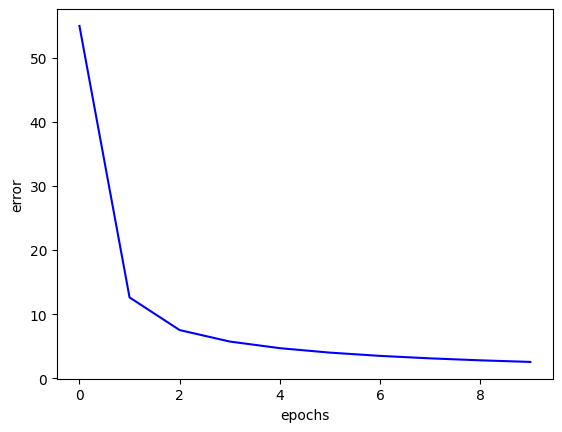

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_learning_curve(train_errors):
    plt.plot(np.arange(10), train_errors, 'b-')
    plt.xlabel('epochs')
    plt.ylabel('error')
plot_learning_curve(losses)

In [ ]:
x, y = reberGrammar.get_one_example(5)
p = prediction(x)

In [ ]:
for pred, target in zip(p, np.array(y)):
  print('target ',target)
  print('pred ', pred, '\n')

target  [0. 1. 0. 0. 1. 0. 0.]
pred  tensor([0.0027, 0.9981, 0.0018, 0.0024, 0.9996, 0.0026, 0.0014]) 

target  [0. 0. 1. 1. 0. 0. 0.]
pred  tensor([8.1255e-04, 1.0384e-02, 9.8393e-01, 9.8499e-01, 5.3235e-05, 2.2454e-03,
        1.0505e-02]) 

target  [0. 0. 1. 1. 0. 0. 0.]
pred  tensor([4.2724e-05, 2.4063e-06, 9.9791e-01, 9.9799e-01, 5.8277e-06, 1.9873e-06,
        4.0989e-03]) 

target  [0. 0. 1. 1. 0. 0. 0.]
pred  tensor([1.2158e-04, 2.0084e-03, 9.9649e-01, 9.9686e-01, 4.8143e-07, 1.5976e-03,
        5.2040e-05]) 

target  [0. 1. 0. 0. 0. 1. 0.]
pred  tensor([3.4958e-04, 9.9937e-01, 1.1828e-04, 1.7417e-04, 1.4488e-04, 9.9996e-01,
        3.5055e-06]) 

target  [0. 0. 0. 0. 1. 1. 0.]
pred  tensor([6.2583e-04, 4.3989e-03, 2.5414e-07, 1.8237e-07, 9.9500e-01, 9.9995e-01,
        6.1451e-03]) 

target  [0. 0. 1. 1. 0. 0. 0.]
pred  tensor([7.3084e-04, 1.5371e-03, 9.9682e-01, 9.9681e-01, 1.1610e-06, 4.6044e-04,
        1.4137e-03]) 

target  [0. 1. 0. 0. 0. 1. 0.]
pred  tensor([5.6380e-04,